<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Aprendizaje por refuerzo: Deep $Q$-learning<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-04-09</small></i></div>
                                                  

***

## Introducción

La implementación más sencilla del $Q$-Learning utiliza una tabla para guardar todos los valores, pero esto se convierte rápidamente en inviable para entornos con muchos estados o acciones posibles.

Utilizando un modelo de red neuronal (profunda) para representar la función $Q(s, a)$, el agente puede generalizar mejor combinaciones no experimentadas de $(s, a)$. La entrada a este modelo sería una observación, mientras que la salida sería un valor $Q$ para cada acción permitida en ese estado. Esta implementación se denomina Deep $Q$-Learning.

## Objetivos

En este notebook vamos a resolver un problema de simulación aplicando aprendizaje por refuerzo, concretamente la técnica de _Deep $Q$-learning_, la cual es la indicada en el caso de procesos de espacio y tiempo continuos.

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del _notebook_.

In [6]:
!pip install gymnasium
!pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/374.4 kB ? eta -:--:--
     -------------------------------------- 374.4/374.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
      --------------------------------------- 0.2/10.4 MB 5.9 MB/s eta 0:00:02
     -- ------------------------------------- 0.5/10.4 MB 5.7 MB/s eta 0:00:02
     --- ------------------------------------ 0.9/10.4 MB 6.5 MB/s eta 0:00:02
     ----- ---------------------------------- 1.3/10.4 MB 7.6 MB/s eta 0:00:02
     ------ --------------------------------- 1.8/10.4 MB 8.3 MB/s eta 0:00:02
     --------- ------------------------------ 2.5/10.4 MB 8.7 MB/s eta 0:00:01
     ----------- --------------------------

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [16 lines of output]
  Using setuptools (version 56.0.0).
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating build\lib.win-amd64-3.9\Box2D
  copying library\Box2D\Box2D.py -> build\lib.win-amd64-3.9\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-3.9\Box2D
  creating build\lib.win-amd64-3.9\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-3.9\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
  swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
  error: command 'swig.exe' failed: None
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a p

In [3]:
from collections import deque
import os
import pathlib
import random
import shutil
from typing import Callable, List,  NamedTuple, Sequence, SupportsFloat, Union
import uuid

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [4]:
%matplotlib notebook
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (15, 8),'figure.dpi': 64})

***

## Entorno de simulación

Vamos a usar el entorno de simulación `LunarLander` de `gymnasium`ya que lo conocemos bastante bien.

In [9]:
env = gym.make('LunarLander-v2')

## Nuestra primera acción será ver el espacio de observaciones y de acciones de nuestro entorno. Tal y como hemos visto durante la teoría:

- Espacio de observaciones: Todos los posibles estados de nuestro entorno que el agente es capaz de ver. En algunos casos se corresponderá con el espacio de estados de nuestro problema, pero no siempre tiene por qué ser así.
- Espacio de acciones: Todas las acciones posibles de nuestro agente sobre el entorno.

In [10]:
print(f'Input: {env.observation_space}')
print(f'Output: {env.action_space}')

Input: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Output: Discrete(4)


Concretamente, los espacios de observaciones y acciones son de tipo `Box` y `Discrete` respectivamente. Esto son clases concretas del entorno `gymnasium`, pero lo importante es que hay 8 entradas que nos indican el estado de la nave en el entorno y cuatro posibles acciones a realizar.

En _Deep $Q$-learning_ los espacios de observaciones y acciones se corresponderán con las entradas y las salidas del modelo que sustituye a la red Q.

Ahora, antes de seguir, vamos a el entorno que hemos creado para no tener problemas.

In [11]:
env.close()

## Elementos auxiliares

Como la implementación será un poco más larga que el _notebook_ anterior, haremos uso de una serie de elementos auxiliares que nos ayudarán ha hacer el código más manejable.

Comenzamos definiendo la clase `Transition`, que representará la transición que ocurre de un estado $s_t$ a un estado $s_{t+1}$. Dicha transición contendrá la información de qué acción provocó la transición, cuál fue la recompensa de haberla llevado a cabo y si se ha terminado, ya sea por llegar a un estado terminal (p.ej. llegar al destino o morir) o por cualquier otra razón (p.ej llegar a un determinado límite de tiempo).

In [12]:
class Transition(NamedTuple):
    """Representa la transición de un estado al siguiente"""
    prev_state: gym.core.ObsType  # Estado origen de la transición
    next_state: gym.core.ObsType  # Estado destino de la transición
    action: gym.core.ActType      # Acción que provocó esta transición
    reward: SupportsFloat         # Recompensa obtenida
    terminated: bool              # Si se ha llegado a un estado terminal

También crearemos un objeto que almacenará la memoria de experiencias vividas por nuestro agente. Estas experiencias se corresponderán con la información de todas las transiciones por las que han pasados los estados en los que se ha ido encontrando.

Se implementará como un _buffer_ de un tamaño determinado, por lo que llegará un momento que las antiguas experiencias se irán eliminando para dar paso a las nuevas. TODO: QUIZÁ EXPLICAR UN POQUITO MÁS CÓMO SE VA A USAR DURANTE EL ENTRENAMIENTO, Y AÑADIR UN DIBUJITO PARA QUE SE VEA CÓMO FUNCIONA.

## Nuestro agente

Vamos a crear un agente que tratará de resolver este problema en el entorno existente. Intentaremos que se parezca en la medida de lo posible al que hemos visto resolviendo el problema del 1Dungeon, pero la implementación será un poco más grande (que no complicada, sólo grande).

Comenzaremos por el principio, un agente que se desenvuelve en un entorno.

```python
class Agent:
    def __init__(self, *, env: gym.Env):
        self.env = env
```

### Tareas

Si recordamos, se denominaba «tarea» a una instancia de un problema, que podía tratarse de una tarea episódica (tiene un comienzo y un fin) o continua (tiene comienzo pero no tiene fin).

El agente, para aprender, ejecutará tareas una detrás de otra. Cada una de ellas constará de un ciclo constante de percibir el entorno, decidir la acción a ejecutar y ejecutar dicha acción sobre el entorno. Esto lo gestionaremos a través del método `task` de nuestro agente.

```python
class Agent:
    def __init__(self, *, env: gym.Env):
        # ...
        self.current_state = None

    def task(self, max_iterations: int=None) -> float:
        self.current_state, _ = env.reset()

        max_iterations = max_iterations or np.inf
        reward = 0
        running = True
        while running and max_iterations > 0:
            # Por si acaso tenemos un número máximo de acciones por tarea
            max_iterations -= 1
            # Ciclo de percibir-decidir-actuar
            perception = self.perceive()
            action = self.decide(perception)
            transition = self.act(action)
            # Añadimos la recompensa de la acción a la recompensa de la tarea
            reward += transition.reward
            # Condición de parada
            running = not transition.terminated
        return reward
```

Como vemos, la tarea reinicia el entorno para comenzar la ejecución, asigna el estado inicial a un atributo del objeto llamado `current_state` y procede a realizar tantas iteraciones de percibir-decidir-actuar como sean necesarias hasta llegar a una solución (i.e. la última transición ha llegado a un estado de finalización) o a un máximo de iteraciones (controlado mediante el argumento `max_iterations`.

Ahora nos quedaría definir cómo se percibe, decide y actúa.

#### Percibir

En nuestro problema vamos a usar como percepción exclusivamente el estado devuelto por el entorno, aunque en otros casos podría usarse otra información adicional (por ejemplo el número de iteraciones que llevamos dentro del episodio para que aprenda a tener prisa si se está acabando el tiempo, por ejemplo).

```python
class Agent:
    # ...
    
    def perceive(self):
        return self.current_state
```

Eso sí, tenemos que tener cuidado para que, cuando actuemos sobre el entorno y éste nos devuelva el nuevo estado, almacenarlo en este atributo. Así, en la siguiente vuelta del bucle cuando toque percibir tendremos disponible el nuevo estado para decidir sobre él. Y hablando de decidir...

#### Decidir

Cuando decimos «decidir» nos referimos a determinar en cada momento queé acción ejecutaremos dada una observación. Pero claro, ya vimos anteriormente que escoger siempre la mejor acción no tiene por qué ser la mejor estrategia de acción. Es más, a menudo las recompensas a largo plazo suelen ser mejores que las de corto plazo.

Por ello, volveremos a usar la estrategia _$\epsilon$-greedy_ con decaimiento, de tal manera que no siempre escogerá la mejor acción, sino que variará dependiendo de en qué momento del entrenamiento estemos, comenzando con una estrategia más aleatoria al principio y más conservadora al final.

Tenemos que hacer, eso sí, una pequeña modificación sobre el método `task` para que reciba el parámetro `epsilon`, así éste será pasado al método `decide` que escojerá la acción a ejecutar.

```python
class Agent:
    def __init__(self, *, env: gym.Env):
        # ...
        self.model = ??

    def task(self, epsilon: float, max_iterations: int=None) -> float:
        # ...
        while running and max_iterations > 0:
            # ...
            action = self.decide(perception, epsilon)
            # ...
        return reward

    # ...

    def decide(self, perception: np.ndarray, epsilon: float) -> np.ndarray:
        if random.random() < epsilon:
            # Selección aleatoria
            return self.env.action_space.sample()
        else:
            # Selección voraz
            perception = perception[np.newaxis, ...]
            q_values = self.model.predict(perception, verbose=0)[0]
            return np.argmax(q_values)
```

Vemos que en el caso de la selección voraz, es decir, la selección de la mejor acción, obtiene los _$q$-values_ de todas las opciones posibles de un modelo predictivo, escogiendo la mejor acción a partir del valor más alto. Más adelante veremos de dónde sale ese modelo. Por ahora vamos a terminar implementando el método dectinado a actuar.

#### Actuar

En este método se ejecutará la acción decidida. En nuestro problema en concreto delegamos totalmente en el entorno en cuestión, pero podría ser que el agente tuviese lógica adicional que hiciese que la transición o la acción pudiese variar.

En nuestro caso, la implementación es muy sencilla:

```python
class Agent:
    # ...

    def act(self, action):
        next_state, reward, terminated, _, _ = self.env.step(action)
        self.current_state = next_state
        
        return Transition(
            prev_state=self.current_state,
            next_state=next_state,
            action=action,
            reward=reward,
            terminated=terminated,
        )
```

### Memoria

Una de las características que tendrá nuestro agente es la memoria. Durante la ejecución del escenario, irá teniendo experiencias, representadas como transiciones entre estados. Esta memoria es la que se usará durante la fase de entrenamiento.

In [13]:
class Memory:
    """Representa la memoria de un agente.

    Concretamente, almacenará las últimas n transiciones realizadas en
    el entorno. El tamaño de la memoria se establecerá en el momento de
    crear la memoria del mismo.

    La memoria guarda las transiciones de manera ordenada, y se podrá
    acceder a ellos por índice, de manera que el recuerdo más lejano
    estará en la posición 0 y el más reciente en la posición -1.
    """

    def __init__(self, size: int):
        """Inicializa el objeto.

        :param size: El tamaño máximo de la memoria del agente."""
        self.max_size = int(size)
        self.transitions: deque = deque(maxlen=self.max_size)

    def append(self, transition: Transition):
        """Añade un nuevo recuerdo a la memoria del agente.

        :param transition: La transición a recordar."""
        self.transitions.append(transition)

    def batch(self, n: int) -> List[Transition]:
        """Devuelve n recuerdos aleatorios de la memoria.

        :param n: El número de recuerdos aleatorios a devolver. Si es
            superior al número de recuerdos totales devolverá todos los
            recuerdos almacenados.
        :returns: La lista de transiciones.
        """
        n = min(len(self.transitions), n)
        return random.sample(self.transitions, n)

    def __len__(self) -> int:
        """El número de recuerdos que contiene esta memoria.

        :returns: Un entero mayor o igual a 0.
        """
        return len(self.transitions)

    def __getitem__(
            self,
            key: Union[int, slice]
    ) -> Union[Transition, Sequence[Transition]]:
        """Devuelve el/los elemento/s especificados.

        :param key: El argumento que indica los elementos. Puede ser un
            entero normal o un slice.
        :returns: El/los elemento/s especificados por el índice.
        """
        return self.transitions.__getitem__(key)

Ahora actualizaremos nuestro agente para que tenga una memoria de acciones.

```python
class Agent:
    def __init__(self, *, env: gym.Env, memory_size: int=1e5):
        # ...
        self.memory = Memory(size=memory_size)

    # ...

    def act(self, action):
        # ...
        self.memory.append(Transition(
            prev_state=self.current_state,
            next_state=next_state,
            action=action,
            reward=reward,
            terminated=terminated,
        ))

        return self.memory[-1]
```

Básicamente actualizamos la memoria justo antes de devolver la transición efectuada.

### Modelo de comportamiento

Como hemos dicho, la tabla $Q$ de la estrategia $Q$-learning se sustituye por un modelo de redes neuronales en _dee $Q$-learning_. Por tanto, habilitaremos al agente para que admita un modelo que será en el que almacenará su experiencia.

Para que sea más versátil, nuestro agente admitirá un modelo de tres formas diferentes:

1. Como función que devuelve un modelo.
1. Directamente como modelo
1. Como cadena de caracteres representando el _path_ donde se encuentra el modelo.

```python
class Agent:
    def __init__(
            self, *,
            env: gym.Env,
            model: Union[Callable[[gym.Env], tf.keras.Model], tf.keras.Model, str],
            memory_size: int = 1e5,
    ):
        # ...
        if callable(model):
            self.model = model(self.env)
        elif isinstance(model, tf.keras.models.Model):
            self.model = tf.keras.models.clone_model(model)
        elif isinstance(model, str):
            self.model = tf.keras.models.load_model(model)
        else:
            raise ValueError('Valid models are a function, a model or a path')
```

Como vemos, este modelo tendrá como entrada el estado del entorno y como salida los cuatro _$q$-values_ asociados a cada acción. Sin embargo, aunque tenemos el modelo, aún no hemos hablado de como entrenarlo.

#### Entrenando nuestro modelo de comportamiento

La idea detrás del aprendizaje en este tipo de algoritmos es que el modelo de entrena cada $x$ pasos a partir de la información recabada del pasado, que está almacenada en memoria.

Esta fase nos obligará (de nuevo) a actualizar el método `act`, así como la creación de algunos argumentos más:

- `train_steps_rate`: Cada cuantas iteraciones entrenamos el modelo.
- `batch_size`: Con cuantas transiciones entrenamos de todas las diponibles en memoria.
- `gamma`: El factor de ajuste que sube o baja la recompensa futura.

Además, creamos un nuevo atributo, `current_step` que nos indica en qué paso del entrenamiento nos encontramos. Con esto explicado, veamos los cambios:

```python
class Agent:
    def __init__(
            self, *,
            env: gym.Env,
            model: Union[Callable[[gym.Env], tf.keras.Model], tf.keras.Model, str],
            train_steps_rate,
            batch_size=32,
            memory_size: int = 1e5,
            gamma=0.99,
    ):
        # ...
        self.train_steps_rate = train_steps_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.current_step = 0
    # ...

    def task(self, epsilon, max_iterations=None):
        self.current_state, _ = env.reset()
        self.current_step = 0
        # ...
        while running and self.current_step < max_iterations:
            # ...
            running = not transition.terminated
            self.current_step += 1  # Ya no hace falta decrementar max_iterations
        return reward

    # ...

    def act(self, action):
        # ...
        self.memory.append(Transition(
            prev_state=self.current_state,
            next_state=next_state,
            action=action,
            reward=reward,
            terminated=terminated,
        ))

        if len(self.memory) > self.batch_size and self.current_step % self.train_steps_rate == 0:
            batch = self.memory.batch(n=self.batch_size)
            inputs = np.array([t.prev_state for t in batch])
            labels = self.compute_labels(batch)
            self.model.fit(
                x=inputs,
                y=labels,
                batch_size=self.batch_size,
                verbose=0,
            )

        return self.memory[-1]
```

Como podemos observar, la actualización del modelo salta cada vez que el número de iteraciones es múltiplo de `train_steps_rate`. Pero hay un detalle que no hemos explicado aún: las _labels_. Lo explicaremos después de hablar de la técnica del doble _deep $Q$-learning_.

#### Doble _Deep $Q$-learning_

A la hora de entrenar se realiza una inferencia antes del cálculo y propagación hacia atrás del error. Cuando usamos el mismo modelo para calcular $Q(s, a)$ y para calcular el _$Q$-value_ de la mejor acción del siguiente estado estamos tendiendo a sobreestimar la recompensa esperada (para más información, el artículo [Double Q-Learning & Double DQN with Python and TensorFlow](https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/) lo describe más en detalle)..

La forma de resolver este problema es manteniendo dos modelos, los cuales se suelen denominar $\Theta$ y $\Theta'$

- $\theta$: Modelo principal del que obtendremos las acciones a realizar.
- $\theta'$: Modelo objetivo, a partir del cual calcularemos los valores objetivo.

Los pesos del modelo principal $\theta$ se copian al modelo objetivo $\theta'$ cada $x$ pasos.

Empíricamente se observa que el uso del doble $q$-learning conduce a valores $Q$ más realistas y, por tanto, a mejores modelos. Nosotros, a los modelos $\theta$ y $\theta'$ los denominaremos `model` y `target_model` respectivamente.

DARLE UNA VUELTA A LA WIKIPEDIA PORQUE HE VISTO QUE SE PUEDE COMPLEMENTAR UN POCO LA INFORMACIÓN: https://es.wikipedia.org/wiki/Q-learning

Ahora vamos a ver los cambios necesarios que tenemos que realizar en nuestro agente para hacer uso de este esquema de aprendizaje.

```python
class Agent:
    def __init__(
            self, *,
            env: gym.Env,
            model: Union[Callable[[gym.Env], tf.keras.Model], tf.keras.Model, str],
            target_model_update_rate,
            train_steps_rate,
            batch_size=32,
            memory_size: int = 1e5,
            gamma=0.99,
    ):
        # ...
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model_update_rate = target_model_update_rate

    # ...

    def act(self, action):
        # ...
        self.memory.append(Transition(
            prev_state=self.current_state,
            next_state=next_state,
            action=action,
            reward=reward,
            terminated=terminated,
        ))

        if self.current_step % self.target_model_update_rate == 0:
            self.target_model.set_weights(self.model.get_weights())

        if len(self.memory) > self.batch_size and self.current_step % self.train_steps_rate == 0:
            # ...
```

Como podemos ver, hemos creado un clon del modelo del agente con la misma arquitectura y pesos para que, cada vez que llevamos cierto número de iteraciones determinadas por el valor de `target_model_update_rate`, volquemos los pesos del modelo base al modelo _target_.

#### Cálculo de las _labels_ para el modelo de comportamiento

Y ahora sí, vamos al asunto de la predicción de los valores. Éstos se tienen que corresponder con los _$q$-values_ óptimos, pero no los conocemos (evidentemente, si no, no estaríamos haciendo todo esto). El modelo terminará aprendiéndolos, por lo que crearemos un conjunto de _$q$-values_ que aproximen las recompensas obtenidas en algunas de las transiciones que hicimos en el pasado (el _batch_ extraído aleatoriamente de la memoria.

Para predecir el valor de la mejor acción del estado futuro usaremos el valor que da `target_model` a la mejor acción predicha por el modelo base.

Con esto ya tenemos una estimación de la mejor acción a elegir para el estado actual, por lo que pondremos a 0 los valores del resto de acciones para que el modelo trate de aproximarse a dicho valor. Veamos una posible implementación del método ``, que es el que usaremos para calcular dichas estimaciones objetivo:

```python
class Agent:
    # ...

    def compute_labels(self, transitions):
        # Tomamos los estados destino de las transiciones del batch
        next_states = np.array([t.next_state for t in transitions])

        # Calculamos los q-values tanto del modelo base como del objetivo
        q_base = self.model.predict(next_states, verbose=0)
        q_target = self.target_model.predict(next_states, verbose=0)

        targets = []
        for i, transition in enumerate(transitions):
            # Seleccionamos la mejor acción
            best_action_base = np.argmax(q_base[i])
            best_action_target = q_target[i][best_action_base]

            # Calculamos su recompensa asociada
            reward = transition.reward
            if not transition.terminated:
                reward += self.gamma * best_action_target

            # Creamos la label de entrenamiento asociada a este ejemplo
            target_vector = [0 for _ in range(self.env.action_space.n)]
            target_vector[transition.action] = reward
            targets.append(target_vector)

        return np.array(targets)
```

### Versión final del agente

Nuestro agente está terminado. La versión final después de todo lo explicado (que no es poco) es la siguiente:

In [14]:
class Agent:
    def __init__(
            self, *,
            env: gym.Env,
            model: Union[Callable[[gym.Env], tf.keras.Model], tf.keras.Model, str],
            target_model_update_rate,
            train_steps_rate,
            batch_size=32,
            memory_size: int = 1e5,
            gamma=0.99,
    ):
        """Inicializa el objeto.
        :param model: El modelo del objeto. Puede ser una función que devuelva
            un nuevo modelo (compilado), un objeto de `tf.keras.Model` ya
            existente (en cuyo caso se clonará) o una cadena con un path
            válido, en cuyo caso se cargará de disco.
        """
        # El entorno en el que vamos a trabajar
        self.env = env

        # El modelo de aprendizaje de nuestro agente
        if callable(model):
            self.model = model(self.env)
        elif isinstance(model, tf.keras.models.Model):
            self.model = tf.keras.models.clone_model(model)
        elif isinstance(model, str):
            self.model = tf.keras.models.load_model(model)
        else:
            raise ValueError('Valid models are a function, a model or a path')

        # El clon del modelo que hace las veces del modelo objetivo
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model_update_rate = target_model_update_rate

        # La memoria de transiciones que mantendrá el agente
        self.memory = Memory(size=memory_size)

        self.train_steps_rate = train_steps_rate
        self.batch_size = batch_size
        self.gamma = gamma

        # Indica en el estado que se encuentra el agente
        self.current_state = None
        # Para llevar la cuenta de cada cuánto toca actualizar el target_model
        self.current_step = 0

    def task(self, epsilon, max_iterations=None):
        self.current_state, _ = env.reset()
        self.current_step = 0

        max_iterations = max_iterations or np.inf
        reward = 0
        running = True
        while running and self.current_step < max_iterations:
            perception = self.perceive()
            action = self.decide(perception, epsilon)
            transition = self.act(action)
            reward += transition.reward
            running = not transition.terminated
            self.current_step += 1
        return reward

    def perceive(self):
        return self.current_state

    def decide(
            self,
            perception: np.ndarray,
            epsilon: float
    ) -> np.ndarray:
        """Decide mediante la estrategia ε-greedy que acción ejecutar.

        El valor de epsilon controla el equilibrio entre selección aleatoria o
        voraz. Cuanto más cercano a 0, más probable será que

        :param perception: El estado del entorno que ha percibido el agente.
        :param epsilon: La probabilidad de que la selección sea aleatoria.
        """
        if random.random() < epsilon:
            # Selección aleatoria
            return self.env.action_space.sample()
        else:
            # Selección voraz
            perception = perception[np.newaxis, ...]
            q_values = self.model.predict(perception, verbose=0)[0]
            return np.argmax(q_values)

    def act(self, action):
        # Ejecutamos la acción
        next_state, reward, terminated, _, _ = self.env.step(action)

        # Actualizamos el estado en el que nos encontramos ahora
        self.current_state = next_state
        
        # Añadimos a la memoria la transición que acabamos de hacer
        self.memory.append(Transition(
            prev_state=self.current_state,
            next_state=next_state,
            action=action,
            reward=reward,
            terminated=terminated,
        ))

        # Comprobamos si toca actualizar el modelo objetivo
        if self.current_step % self.target_model_update_rate == 0:
            self.target_model.set_weights(self.model.get_weights())

        # Comprobamos si toca actualizar el modelo base
        if len(self.memory) > self.batch_size and self.current_step % self.train_steps_rate == 0:
            # Entrenamos con un batch aleatorio de la memoria del agente
            batch = self.memory.batch(n=self.batch_size)
            self.model.fit(
                x=np.array([t.prev_state for t in batch]),
                y=self.compute_labels(batch),
                batch_size=self.batch_size,
                verbose=0,
            )

        return self.memory[-1]

    def compute_labels(self, transitions):
        """Para entrenar necesitamos saber cuál es la acción que queremos
           predecir. Para ello lo que haremos será mantener activa únicamente
           aquella acción que mejor resultado nos da, dejando el resto de
           acciones a 0."""
        # Tomamos los estados destino de las transiciones del batch
        next_states = np.array([t.next_state for t in transitions])

        # Calculamos los q-values tanto del modelo base como del objetivo
        q_base = self.model.predict(next_states, verbose=0)
        q_target = self.target_model.predict(next_states, verbose=0)

        targets = []
        for i, transition in enumerate(transitions):
            # Seleccionamos la mejor acción
            best_action_base = np.argmax(q_base[i])
            best_action_target = q_target[i][best_action_base]

            # Calculamos su recompensa asociada
            reward = transition.reward
            if not transition.terminated:
                reward += self.gamma * best_action_target

            # Creamos la label de entrenamiento asociada a este ejemplo
            target_vector = [0 for _ in range(self.env.action_space.n)]
            target_vector[transition.action] = reward
            targets.append(target_vector)

        return np.array(targets)

Ahora vamos a definir un modelo que entrenaremos para que nuestro agente aprenda.

## Creación del modelo

Nuetro modelo será una red neuronal de tipo perceptrón multicapa con $8$ entradas, correspondientes a las 8 observaciones del módulo lunar, y $4$ salidas, correspondientes a las 4 acciones posibles.

Sin embargo, vamos a introducir una última modificación (y de verdad que es la última) a la forma en la que hemos estado creando los modelos hasta ahora.

Si usamos el error cuadrático medio (MSE) como función de pérdida, es muy probable que los errores durante el entrenamiento sean extremadamente altos. El problema de que aparezcan errores muy altos continuadamente es que existe el riesgo (también muy alto) de que el modelo se sobreajuste, y por tanto de que no llegue a una buena solución. Para ello usaremos la función de pérdida de _Huber_, pero un poco modificada. Veamos cómo.

### _Huber loss_ (un poco a medida)

La función de pérdida de Huber es bastante menos sensible a los valores atípicos que la MSE porque es exponencial sólo hasta cierto umbral, a partir del cual se convierte en lineal. Esto conduce que la convergencia del proceso de entrenamieto sea más estable.

Keras implementa la función de pérdida de Huber (`tf.keras.losses.Huber`), donde se le especifica a partir de qué valor de $x$ (mediante el parámetro `delta`) se empieza a comportar como lineal en lugar de cuadrática.

Ahora bien, nuestro modelo toma como entrada un estado $s_t$, y como salida **todos** los valores $Q$ de todas las acciones posibles. Si queremos actualizar el modelo para que aprenda de haber transicionado del estado $s_t$ al estado $s_{t+1}$, sólo querremos calcular el _loss_ de la salida de la acción para dicha transición.

Por ello, implementaremos una función un poco diferente que haga esto:

In [15]:
def custom_huber_loss(delta):
    """Función de pérdida de huber pero personalizada.

    En este caso, la pérdida se calculará sólo para aquellos valores que
    sean distintos de 0.

    :param delta: Determina el intervalo (-delta, delta) según el cual
        todos aquellos valores que quedan dentro del intervalo tienen un
        error cuadrático, y fuera un error lineal.
    :returns: La función de pérdida configurada para el parámetro delta.
    """
    half = tf.constant(0.5, dtype=tf.keras.backend.floatx())

    def f(y, ŷ):
        # Máscara para todas aquellas acciones que no son 0 (es decir,
        # las que no provocaron la transición)
        mask = tf.cast(tf.not_equal(y, 0.0), tf.keras.backend.floatx())
        # Error cometido en aquellas acciones válidas (valor absoluto)
        error = tf.abs(y - ŷ) * mask
        # Dependiendo de delta, calculamos error cuadrático o lineal
        loss = tf.where(
            error < delta,
            half * tf.square(error),  # Error cuadrático
            delta * (error - half * delta)  # Error lineal
        )
        # El loss será la media de todos los valores distintos de cero
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    f.__name__ = 'custom_huber_loss'
    return f

Por ejemplo, supongamos que nuestro agente tiene 4 acciones disponibles. En dicho caso, nuestro modelo podría predecir `[1, 2, 3, 4]` como valores $Q$. Si en la transición de estado sobre la que estamos entrenando tomamos la acción 3 y obtuvimos un valor objetivo de 6, entonces obtenemos un vector objetivo de `[6, 0, 0, 0]`. Nuestra función hará un paso previo de anular las salidas cuyo `y` es `0` para aplicar el error correctamente, usando al final los vectores `y = [1, 0, 0, 0]` e `ŷ = [0, 0, 12, 0]`.

### El modelo de nuestro agente

Ahora sí que sí, ya tenemos todo para crear nuestro modelo. Crearemos una función que es la que le pasaremos a nuestro agente para que la construya cuando lo necesite.

In [16]:
def build_model(env: gym.Env) -> tf.keras.models.Model:
    """Crea un nuevo modelo con nuestro agente."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU(0.2), input_shape=env.observation_space.shape),
        tf.keras.layers.Dense(env.action_space.n, activation='linear'),
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=custom_huber_loss(1))
    return model

Podemos ver que nuestro modelo se compila usando la función de pérdida de _Huber_ que hemos definido previamente.

## Aprendiendo a aterrizar el módulo lunar

Ahora ya tenemos todas las piezas disponibles para que nuestro módulo lunar aprenda. Vamos allá:

<IPython.core.display.Javascript object>


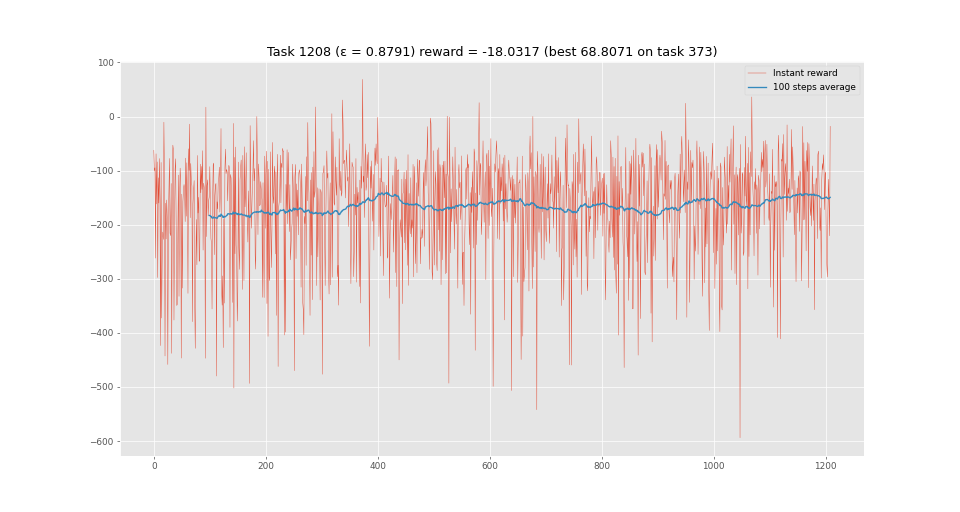

In [ ]:
# Para la duración del entrenamiento
NUM_TASKS = 10000
MAX_STEPS_PER_TASK = 1000

# Para la implementación del ε-greedy con desvanecimiento
EPSILON_MAX = 1.
EPSILON_MIN = 0.01
EPSILON_DEC = EPSILON_MAX / NUM_TASKS

# Ventana de la media móvil (para el plot)
RUNNING_AVG_WINDOW_SIZE = 100

# Por si queremos usar un modelo previamente salvado
def existing_model(task_num):
    def f():
        """Carga un modelo salvado previamente"""
        path = f'tmp/lunar-lander-{task_num}.h5'
        return tf.keras.models.load_model(path, custom_objects={
            'custom_huber_loss': custom_huber_loss(1)
        })
    return f

env = gym.make('LunarLander-v2')

agent = Agent(
    env=env,
    model=build_model,
    target_model_update_rate=2**8,
    train_steps_rate=4,
    memory_size=2**16,
    batch_size=2**12,
    gamma=0.99,
)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('Task')
ax.set_ylabel('Reward')

epsilon = EPSILON_MAX
rewards = []
rewards_avg = []
for task in range(NUM_TASKS):
    # Reseteamos el entorno y el agente para comenzar un nuevo episodio
    reward = agent.task(epsilon=epsilon, max_iterations=MAX_STEPS_PER_TASK)

    # Salvamos el modelo
    agent.model.save(f"tmp/lunar-lander-{task}.h5")

    # Actualizamos el valor de epsilon
    epsilon = max(EPSILON_MIN, epsilon - EPSILON_DEC)

    # Actualizamos el histórico de valores
    rewards.append(reward)
    if len(rewards) < RUNNING_AVG_WINDOW_SIZE:
        rewards_avg.append(np.nan)
    else:
        rewards_avg.append(np.mean(rewards[-RUNNING_AVG_WINDOW_SIZE:]))

    # Pintamos la gráfica
    ax.cla()
    ax.set_title(f'Task {task} (ε = {epsilon:5.4f}) reward = {reward:5.4f} (best {max(rewards):5.4f} on task {np.argmax(rewards)})')
    ax.plot(rewards, linewidth=0.5, label='Instant reward')
    ax.plot(rewards_avg, linewidth=1.5, label=f'{RUNNING_AVG_WINDOW_SIZE} steps average')
    ax.legend()
    fig.canvas.draw()
    
    # HE ACOTADO EL ERROR DEL MEMORY LEAK AL FIT O PREDICT DEL MODELO. POR LO
    # VISTO SE VA OCUPANDO MEMORIA POR ALGUNA RAZÓN. A LO MEJOR LOS TENSORES
    # QUE SE CREAN PARA EL INPUT SE AÑADEN AL GRAFO Y NUNCA SE LIBERAN, PERO
    # NO SÉ CÓMO MIRARLO.
    tf.keras.backend.clear_session()

env.close()

## Resultados

DESCRIBIR CÓMO HA IDO LA PROGRESIÓN DEL ENTRENAMIENTO (ESPEREMOS QUE BIEN)

Vamos a ver cómo se comporta el módulo lunar que mejor recompensa ha tenido.

In [ ]:
BEST_TASK = np.argmax(rewards)

env = gym.make('LunarLander-v2', render_mode='human')
path = F'tmp/lunar-lander-{BEST_TASK}.h5'
model = tf.keras.models.load_model(path, custom_objects={
    'custom_huber_loss': custom_huber_loss(1)
})

state, _ = env.reset()

terminated = truncated = False
while not (terminated or truncated):
    # Seleccionamos una acción dado el actual estado ...
    action = np.argmax(model.predict(state[np.newaxis, ...], verbose=0)[0])
    # ... y la ejecutamos, obteniendo el nuevo estado
    state, _, terminated, truncated, _ = env.step(action)
env.close()

ESCRIBIR LAS CONCLUSIONES SOBRE EL ENTRENAMIENTO CUANDO NO SE FUNDA LA MEMORIA DE MI MÁQUINA.

## Conclusiones

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>